In [1]:
import numpy
import models
from sklearn.decomposition import PCA
import pandas
import datasets

In [4]:
df = pandas.read_excel("Data/Geochemical Analysis 20220911.xlsx")

In [10]:
(df["DEPTH"] == " ").sum()/23843

23047

In [11]:
df.shape

(23843, 102)

In [2]:
geochemical_analysis = datasets.geochemical_analysis()

x_labels_1 = ["V", "CR", "CO", "NI", "CU", "ZN", "GA", "SR", "Y", "NB", "ZR", "CE", "PR", "ND", "P2O5", "MNO", "CAO", "NA2O"]
#x_labels = ["RB", "K2O", "YB", "LA", "MGO", "U", "BA", "TH", "SN"]
x_labels_2 = ["RB", "K2O", "YB", "LA", "MGO", "U", "BA", "TH", "SN", "Rb_K2O", "Rb_Yb", "Rb_La", "K2O_MgO", "Rb_MgO", "U_Ba", "Ba_La", "U_Th", "Rb_Sn", "K2O_Sn"]
#x_labels = ["Rb_K2O", "Rb_Yb", "Rb_La", "K2O_MgO", "Rb_MgO", "U_Ba", "Ba_La", "U_Th", "Rb_Sn", "K2O_Sn"]
y_labels = ["LI"]

geochemical_analysis_clean = geochemical_analysis[x_labels_1 + x_labels_2 + y_labels].dropna()

In [104]:
geochemical_analysis_train = geochemical_analysis_clean.sample(frac=0.8, random_state=100)
geochemical_analysis_test = geochemical_analysis_clean.drop(geochemical_analysis_train.index)

x_train_1 = geochemical_analysis_train[x_labels_1].to_numpy(numpy.float32)
x_train_2 = geochemical_analysis_train[x_labels_2].to_numpy(numpy.float32)
y_train = geochemical_analysis_train[y_labels].to_numpy(numpy.float32)

x_test = geochemical_analysis_test[x_labels_1 + x_labels_2].to_numpy(numpy.float32)
y_test = geochemical_analysis_test[y_labels].to_numpy(numpy.float32)

model_1 = models.neural_network(x_train_1.shape[1], 3)
model_2 = models.neural_network(x_train_2.shape[1], 3)

model_1.summary()
model_2.summary()

Model: "LithiumPPM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 18)]              0         
                                                                 
 dense_85 (Dense)            (None, 64)                1216      
                                                                 
 dense_86 (Dense)            (None, 64)                4160      
                                                                 
 dense_87 (Dense)            (None, 64)                4160      
                                                                 
 dense_88 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Model: "LithiumPPM"
__________________________________

In [110]:
history_1 = model_1.fit(x_train_1, y_train, batch_size=64, epochs=10, validation_split=0.2)
history_2 = model_2.fit(x_train_2, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
30/30 [==============================] - 0s 3ms/step - loss: 3007.2461 - mean_absolute_error: 22.9935 - mean_squared_error: 3007.2461 - root_mean_squared_error: 54.8384 - val_loss: 1202.8248 - val_mean_absolute_error: 18.3723 - val_mean_squared_error: 1202.8248 - val_root_mean_squared_error: 34.6818
Epoch 2/10
30/30 [==============================] - 0s 791us/step - loss: 2636.6392 - mean_absolute_error: 21.3756 - mean_squared_error: 2636.6392 - root_mean_squared_error: 51.3482 - val_loss: 1155.6367 - val_mean_absolute_error: 19.8631 - val_mean_squared_error: 1155.6367 - val_root_mean_squared_error: 33.9947
Epoch 3/10
30/30 [==============================] - 0s 784us/step - loss: 2301.0945 - mean_absolute_error: 19.4998 - mean_squared_error: 2301.0945 - root_mean_squared_error: 47.9697 - val_loss: 979.9287 - val_mean_absolute_error: 17.5977 - val_mean_squared_error: 979.9287 - val_root_mean_squared_error: 31.3038
Epoch 4/10
30/30 [==============================] - 0s 786us/s

In [99]:
y_predict_1 = model.predict(x_test)
comparison = pandas.DataFrame()
comparison["LI_Predicted"] = y_predict[:,0]
comparison["LI_Actual"] = y_test[:,0]

lithium_threshold = 80

comparison["LI_Predicted_Threshold"] = comparison["LI_Predicted"].ge(lithium_threshold)
comparison["LI_Actual_Threshold"] = comparison["LI_Actual"].ge(lithium_threshold)

19/19 [==============================] - 0s 287us/step


In [100]:
tp = fp = tn = fn = float(0)

for index, row in comparison.iterrows():
    predicted = row["LI_Predicted_Threshold"]
    actual = row["LI_Actual_Threshold"]

    if predicted:
        if actual:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if actual:
            fn = fn + 1
        else:
            tn = tn + 1

accuracy = (tn + tp) / (tn + fp + tp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

In [101]:
print(f"Number of Training Samples: {x_train.shape[0]}")
print(f"Number of Test Samples: {x_test.shape[0]}")
print(f"True Positives = {int(tp)}")
print(f"False Positives = {int(fp)}")
print(f"True Negatives = {int(tn)}")
print(f"False Negatives = {int(fn)}")
print(f"accuracy = {accuracy}")
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {f1}")

Number of Training Samples: 2347
Number of Test Samples: 587
True Positives = 9
False Positives = 1
True Negatives = 560
False Negatives = 17
accuracy = 0.969335604770017
precision = 0.9
recall = 0.34615384615384615
f1 = 0.5


In [102]:
geochemical_analysis_clean.shape

(2934, 38)

In [109]:
test_scores

[1826.430419921875, 16.76494026184082, 1826.430419921875, 42.73675537109375]

In [111]:
y_predict_1 = model_1.predict(geochemical_analysis_test[x_labels_1])
y_predict_2 = model_2.predict(geochemical_analysis_test[x_labels_2])

19/19 [==============================] - 0s 324us/step


In [113]:
y_predict_1.shape

(587, 1)

In [117]:
comparison = pandas.DataFrame()
comparison["LI_Predicted_1"] = y_predict_1[:,0]
comparison["LI_Predicted_2"] = y_predict_2[:,0]
comparison["LI_Actual"] = y_test[:,0]

In [118]:
import matplotlib.pyplot as plt 

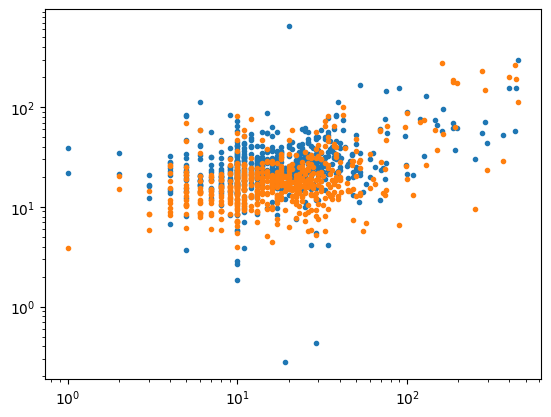

In [126]:
plt.plot(y_test[:,0], y_predict_1[:,0], ".")
plt.plot(y_test[:,0], y_predict_2[:,0], ".")
plt.yscale("log")
plt.xscale("log")

In [148]:
pred_pos_1 = y_predict_1[:,0] > 80
pred_pos_2 = y_predict_2[:,0] > 80
test_pos = y_test[:,0] > 80

In [149]:
model_2 = (pred_pos_2 == True) * (test_pos == True)
model1_residual = (pred_pos_1 == True) * (pred_pos_2 == False) * (test_pos == True)

print(model_2.sum())
print(model1_residual.sum())

11
3


In [173]:
print("Count: " + str(test_pos.shape[0]))
print("Actual Positives: " + str(test_pos.sum()))
print("Actual Negatives: " + str(test_pos.shape[0] - test_pos.sum()))

print("============================================")
print("Model 1 True Positives: " + str(((pred_pos_1 == test_pos)*pred_pos_1).sum()))
print("Model 1 False Positives: " + str(((pred_pos_1 != test_pos)*pred_pos_1).sum()))

print("Model 2 True Positives: " + str(((pred_pos_2 == test_pos)*pred_pos_2).sum()))
print("Model 2 False Positives: " + str(((pred_pos_2 != test_pos)*pred_pos_2).sum()))

print("============================================")
print("Model 1 True Negatives: " + str(((pred_pos_1 == test_pos)*(pred_pos_1 == False)).sum()))
print("Model 1 False Negatives: " + str(((pred_pos_1 != test_pos)*(pred_pos_1 == False)).sum()))

print("Model 2 True Negatives: " + str(((pred_pos_2 == test_pos)*(pred_pos_2 == False)).sum()))
print("Model 2 False Negatives: " + str(((pred_pos_2 != test_pos)*(pred_pos_2 == False)).sum()))

print("============================================")
print("Model 1 Residual True Positives: " + str(((pred_pos_1 == test_pos)*(pred_pos_1)*(pred_pos_2 == False)).sum()))
print("Model 2 Residual True Positives: " + str(((pred_pos_2 == test_pos)*(pred_pos_2)*(pred_pos_1 == False)).sum()))

Count: 587
Actual Positives: 26
Actual Negatives: 561
Model 1 True Positives: 7
Model 1 False Positives: 11
Model 2 True Positives: 11
Model 2 False Positives: 4
Model 1 True Negatives: 550
Model 1 False Negatives: 19
Model 2 True Negatives: 557
Model 2 False Negatives: 15
Model 1 Residual True Positives: 3
Model 2 Residual True Positives: 7


zsh:1: command not found: pred_pos_2


In [168]:
geochemical_analysis_clean.shape

(2934, 38)

In [197]:
x_labels = ["RB", "K2O", "YB", "LA", "MGO", "U", "BA", "TH", "SN"]
#x_labels = ["Rb_K2O", "Rb_Yb", "Rb_La", "K2O_MgO", "Rb_MgO", "U_Ba", "Ba_La", "U_Th", "Rb_Sn", "K2O_Sn"]
geochemical_analysis_clean = geochemical_analysis[x_labels + y_labels].dropna()

In [198]:
from sklearn.decomposition import PCA

In [213]:
pca = PCA()

for label in [x_labels + y_labels]:
    geochemical_analysis_clean[label] = geochemical_analysis_clean[label]/geochemical_analysis_clean[label].mean()

pca.fit(geochemical_analysis_clean)

PCA()

In [214]:
pca.components_[0][:-1]

array([ 9.78320256e-04,  8.02222574e-04, -4.45794299e-04, -8.12171590e-04,
       -7.64464157e-04,  9.99996059e-01, -4.86876748e-05, -6.44748286e-05,
        2.07471507e-03])

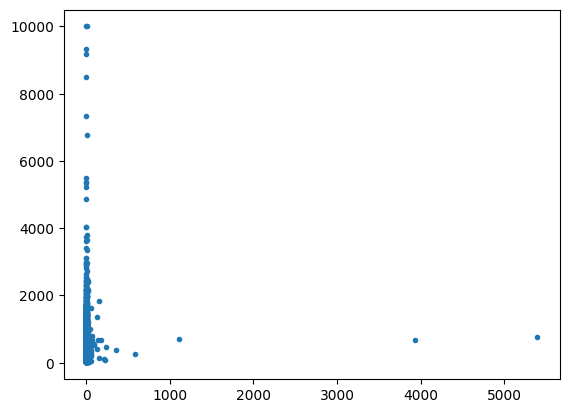

In [209]:
plt.plot(geochemical_analysis_clean["U"], geochemical_analysis_clean["BA"], ".")

In [215]:
geochemical_analysis_clean["RB"].mean()

1.0